### Se importan las librerías necesarias

In [3]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import auc
from scipy.optimize import curve_fit
%matplotlib inline

In [134]:
# Esta función regresa la intensidad total del haz y el coeficiente de atenuación
# del medio.


def intensidad_y_coeficiente(archivo_tsv, pixeles_por_cm, concentracion):
    
    # Se lee el archivo data que debe ser un .tsv (tab seprated values) y se le da
    # el formato adecuado para su análisis
    txt = np.genfromtxt(f"../data/imagenes_texto/{archivo_tsv}", delimiter="\t")
    m,n = txt.shape
    R,C = np.mgrid[:m,:n]
    out = np.column_stack((C.ravel(),R.ravel(), txt.ravel()))
    df = pd.DataFrame(out, columns = ["x",'y','z'])
    df = df.astype(int)
    df["x_cm"] = df["x"] / pixeles_por_cm
    df["y_cm"] = df["y"] / pixeles_por_cm
    df["z"] = df["z"]
    df["y_cm"] = df["y_cm"][::-1].reset_index() / pixeles_por_cm / pixeles_por_cm
    
    print("\n------------------------------------------------\n")
    print(f'El archivo arojó un dataframe de {df.shape[0]} registros y {df.shape[1]} columnas')
    print("\n------------------------------------------------\n")
   
    # se crea un diccionario auxiliar donde almacenar cada uno de los slices 
    # de la imagen.
    aux_dicc = {}
    y_max = max(df["y"])
    df_split = df.copy()
    for i in range(y_max + 1):
        aux_dicc[f"df_{i}"] = df_split[df_split["y"] == i]
    
    
    # Se obtiene la intensidad para cada slice y se guarda en la lista intensidades_slice
    intensidades_slice = [auc(aux_dicc[f"df_{i}"]["x_cm"], aux_dicc[f"df_{i}"]["z"]) for i in range(y_max + 1)]
    df_nuevo = pd.DataFrame(intensidades_slice, columns=["intensidad"])
    df_nuevo["y_cm"] = pd.DataFrame(range(y_max + 1), columns=["y_cm"])
    df_nuevo["y_cm"] = df_nuevo["y_cm"] / pixeles_por_cm
    intervalo = df_nuevo["y_cm"].diff().mean()
    df_nuevo["atenuacion"] = 10 * np.log(df_nuevo["intensidad"] / df_nuevo["intensidad"].shift(1))
    # df_nuevo["intensidad"] = df_nuevo["intensidad"].iloc[:-1]
    
    # Se mustra el encabezado del dataframe con los valores en el eje "y" y sus respectivas
    # intensidades
    print("\n----------------Intensidades----------------------\n")
    print(f"{df_nuevo.head()}")
    print("\n------------------------------------------------\n")
    
    # Se resuelve la integral por el método del trapezoide
    intensidad_total = round(auc(df_nuevo["y_cm"], df_nuevo["intensidad"]), 3)
    atenuacion = round(df_nuevo["atenuacion"].mean(), 3)
    atenuacion_desv_est = round(df_nuevo["atenuacion"].std(), 3)
    
    print(f"La intesidad total del haz en la región es: {intensidad_total}\n")
    print(f"El coeficiente de atenuación es: {atenuacion} +/- {atenuacion_desv_est}")
    #print(f'\t\t\tError porcentual: {round(atenuacion_desv_est / atenuacion * 100, 3)}%')
    
    
    print("\n------------------------------------------------\n")
    
    print("------------- Gráfica de los puntos ---------------\n")
    
    # Se muestra la gráfica de los puntos de las intensidades
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(df["y_cm"], df["x_cm"], df["z"], c=df["z"], cmap='Greens')
    ax.set_title("Intensidad del Haz")
    ax.set_xlabel("Eje y [cm]")
    ax.set_ylabel("Eje x [cm]")
    ax.set_zlabel("Intensidad")
    fig.savefig(f"graficas/final_Grafica_3D:{concentracion}.png")
    return df_nuevo
    


In [135]:
def ajuste(data_frame, concentracion):
    x = data_frame["y_cm"][::-1]
    y = data_frame["intensidad"].fillna(0)
    
    popt, _ = curve_fit(exp_decay, x, y, maxfev=4000)
    a, b = popt

    print(f'a = {round(a, 3)} +/- {round(np.sqrt(np.diag(_))[0], 3)}\nb = {round(b, 3)} +/- {round(np.sqrt(np.diag(_))[1], 3)}')
    
    plt.scatter(x, y, label="Datos\nExperimentales")
    
    # Se crea un array con el dominio de x
    x_line = np.arange(min(x), max(x), 0.01)

    # Se evalua la función en el dominio x_line
    y_line = exp_decay(x_line, a, b)

    # Se grafica el ajuste y_line
    plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=a*exp(-b*x)$")
    plt.xlabel("Posición [cm]")
    plt.ylabel("Intensidad Lumínica Relativa")
    plt.title(f"Ajuste lineal de la intensidad lumínica")
    plt.legend()
    plt.grid()
    plt.savefig(f"graficas/final_ajuste_intensidad_{concentracion}.png")

In [136]:
def recta(x, a, b):
    return a * x + b

In [137]:
def exp_decay(x, a, b):
    return a * np.exp(-b * x)

##### Medio con concentración grenetina/agua 3:1


------------------------------------------------

El archivo arojó un dataframe de 30814 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0   21.200819  0.000000         NaN
1   21.330745  0.015285    0.061096
2   21.475956  0.030571    0.067845
3   21.743450  0.045856    0.123786
4   22.033872  0.061142    0.132684

------------------------------------------------

La intesidad total del haz en la región es: 420.389

El coeficiente de atenuación es: 0.028 +/- 0.109

------------------------------------------------

------------- Gráfica de los puntos ---------------



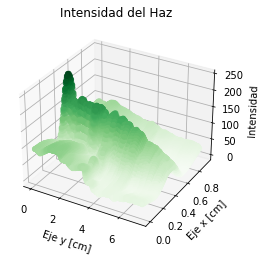

In [138]:
gg_1 = intensidad_y_coeficiente("long_31_recortada.tsv", 65.422, "31")

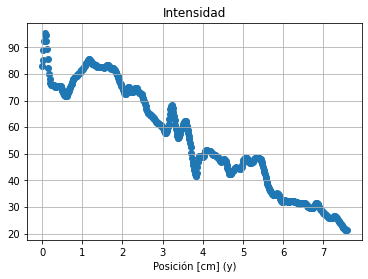

In [150]:
x = gg_1["y_cm"][::-1]
y = gg_1["intensidad"].fillna(0)
plt.scatter(x, y, label="Datos\nExperimentales")
plt.title("Intensidad")
plt.xlabel("Posición [cm] (y)")
plt.grid()
plt.savefig("graficas/final_intensidad_31.png")

C:\Users\eherr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


a = 93.49 +/- 0.713
b = 0.151 +/- 0.002


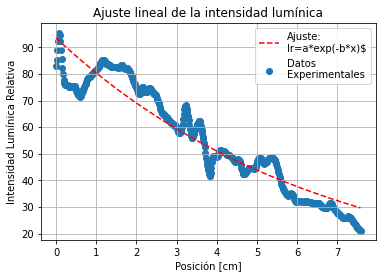

In [140]:
ajuste(gg_1, "31")

##### Medio con concentración grenetina/agua 1:1


------------------------------------------------

El archivo arojó un dataframe de 227622 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0   29.610572  0.000000         NaN
1   29.719128  0.007237    0.036594
2   29.813211  0.014474    0.031607
3   29.867489  0.021711    0.018190
4   30.265529  0.028948    0.132389

------------------------------------------------

La intesidad total del haz en la región es: 526.971

El coeficiente de atenuación es: 0.004 +/- 0.053

------------------------------------------------

------------- Gráfica de los puntos ---------------



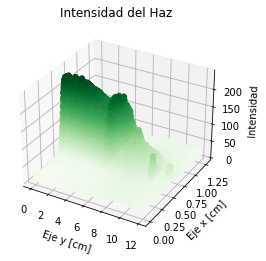

In [105]:
gg_2 = intensidad_y_coeficiente("long_11_recortada.tsv", 138.177)

a = -0.0036520247440192666 +/- 0.0005409217371941874
b = 0.021096253700345735 +/- 0.0029048629752661233


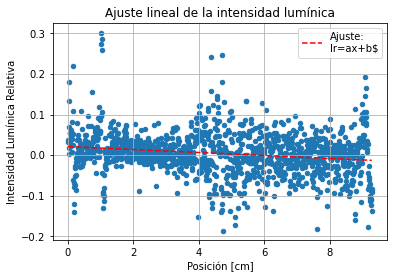

In [117]:
gg_2.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")
popt, _ = curve_fit(recta, gg_2["y_cm"], gg_2["atenuacion"].fillna(0), maxfev=4000)
a, b = popt
print(f'a = {a} +/- {np.sqrt(np.diag(_))[0]}\nb = {b} +/- {np.sqrt(np.diag(_))[1]}')
x_line = np.arange(min(gg_2["y_cm"]), max(gg_2["y_cm"]), 0.01)
y_line = recta(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=ax+b$")
plt.xlabel("Posición [cm]")
plt.ylabel("Intensidad Lumínica Relativa")
plt.title(f"Ajuste lineal de la intensidad lumínica")
plt.legend()
plt.grid()

C:\Users\eherr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


a = 66.589 +/- 0.517
b = 0.036 +/- 0.002


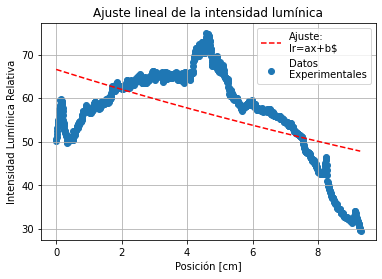

In [107]:
ajuste(gg_2, 1)

##### Medio con concentración grenetina/agua 6:1




------------------------------------------------

El archivo arojó un dataframe de 38927 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0   59.704730  0.000000         NaN
1   59.673746  0.015492   -0.005191
2   59.596288  0.030983   -0.012989
3   59.565305  0.046475   -0.005200
4   59.666001  0.061967    0.016891

------------------------------------------------

La intesidad total del haz en la región es: 624.027

El coeficiente de atenuación es: 0.002 +/- 0.041

------------------------------------------------

------------- Gráfica de los puntos ---------------



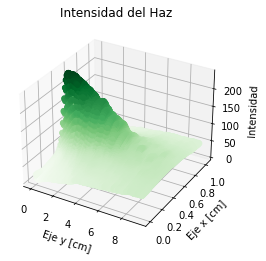

In [108]:
gg_3 = intensidad_y_coeficiente("long_61_recortada.tsv", 64.551)

a = -0.001989435507851969 +/- 0.0006417227777247461
b = 0.010934135730706849 +/- 0.0033304196702083626


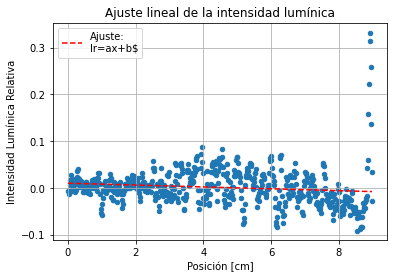

In [109]:
gg_3.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")
popt, _ = curve_fit(recta, gg_3["y_cm"], gg_3["atenuacion"].fillna(0), maxfev=4000)
a, b = popt
print(f'a = {a} +/- {np.sqrt(np.diag(_))[0]}\nb = {b} +/- {np.sqrt(np.diag(_))[1]}')
x_line = np.arange(min(gg_3["y_cm"]), max(gg_3["y_cm"]), 0.01)
y_line = recta(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=ax+b$")
plt.xlabel("Posición [cm]")
plt.ylabel("Intensidad Lumínica Relativa")
plt.title(f"Ajuste lineal de la intensidad lumínica")
plt.legend()
plt.grid()
plt.savefig(f"graficas/ajuste_intensidad_61.png")

C:\Users\eherr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


a = 77.583 +/- 0.552
b = 0.025 +/- 0.001


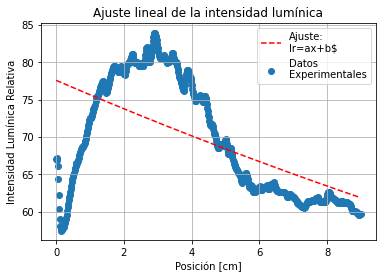

In [110]:
ajuste(gg_3, 6)


------------------------------------------------

El archivo arojó un dataframe de 12780 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0   47.525347  0.000000         NaN
1   47.510327  0.015021   -0.003161
2   47.495306  0.030041   -0.003162
3   47.510327  0.045062    0.003162
4   47.607961  0.060083    0.020529

------------------------------------------------

La intesidad total del haz en la región es: 235.77

El coeficiente de atenuación es: 0.015 +/- 0.03

------------------------------------------------

------------- Gráfica de los puntos ---------------



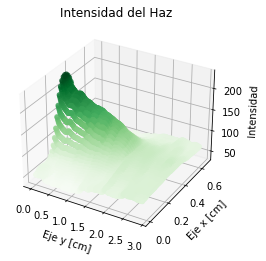

In [141]:
gg_silicon = intensidad_y_coeficiente("long_silicon_recordata.tsv", 66.575, "silicon")

a = 0.00691102277582778 +/- 0.00136675281453074
b = 0.0006837452381355247 +/- 0.003357282979598528


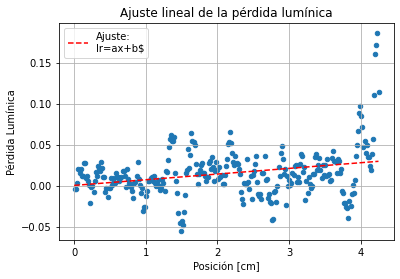

In [144]:
gg_silicon.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")
popt, _ = curve_fit(recta, gg_silicon["y_cm"], gg_silicon["atenuacion"].fillna(0), maxfev=4000)
a, b = popt
print(f'a = {a} +/- {np.sqrt(np.diag(_))[0]}\nb = {b} +/- {np.sqrt(np.diag(_))[1]}')
x_line = np.arange(min(gg_silicon["y_cm"]), max(gg_silicon["y_cm"]), 0.01)
y_line = recta(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=ax+b$")
plt.xlabel("Posición [cm]")
plt.ylabel("Pérdida Lumínica")
plt.title(f"Ajuste lineal de la pérdida lumínica")
plt.legend()
plt.grid()
plt.savefig(f"graficas/final_ajuste_intensidad_silicon.png")

C:\Users\eherr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


a = 66.072 +/- 0.163
b = 0.085 +/- 0.001


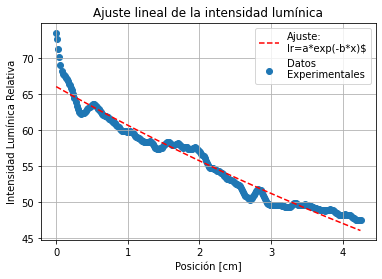

In [143]:
ajuste(gg_silicon, "silicon")


------------------------------------------------

El archivo arojó un dataframe de 45936 registros y 5 columnas

------------------------------------------------


----------------Intensidades----------------------

   intensidad      y_cm  atenuacion
0   69.861059  0.000000         NaN
1   69.876080  0.015021    0.002150
2   70.018776  0.030041    0.020401
3   70.153962  0.045062    0.019288
4   70.304168  0.060083    0.021388

------------------------------------------------

La intesidad total del haz en la región es: 723.652

El coeficiente de atenuación es: 0.004 +/- 0.02

------------------------------------------------

------------- Gráfica de los puntos ---------------



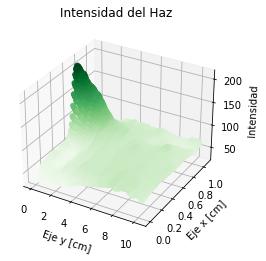

In [114]:
gg_silicon = intensidad_y_coeficiente("buena.tsv", 66.575)

a = 0.0007662929410114927 +/- 0.00028713748156873245
b = 2.11348371310649e-05 +/- 0.0015868204431197497


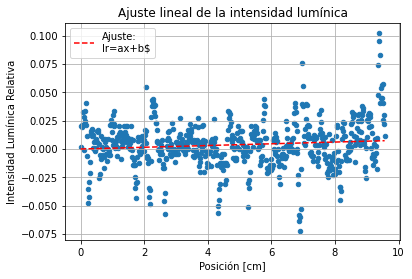

In [115]:
gg_silicon.plot.scatter(x="y_cm", y="atenuacion")
plt.title("Atenuacion")
popt, _ = curve_fit(recta, gg_silicon["y_cm"], gg_silicon["atenuacion"].fillna(0), maxfev=4000)
a, b = popt
print(f'a = {a} +/- {np.sqrt(np.diag(_))[0]}\nb = {b} +/- {np.sqrt(np.diag(_))[1]}')
x_line = np.arange(min(gg_silicon["y_cm"]), max(gg_silicon["y_cm"]), 0.01)
y_line = recta(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red', label="Ajuste:\nIr=ax+b$")
plt.xlabel("Posición [cm]")
plt.ylabel("Intensidad Lumínica Relativa")
plt.title(f"Ajuste lineal de la intensidad lumínica")
plt.legend()
plt.grid()
plt.savefig(f"graficas/ajuste_intensidad_61.png")

C:\Users\eherr\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


a = 79.642 +/- 0.134
b = 0.011 +/- 0.0


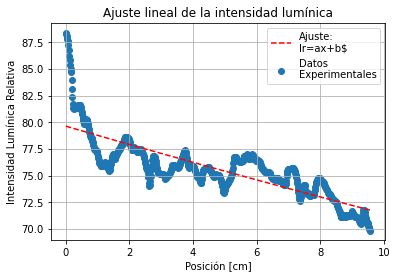

In [116]:
ajuste(gg_silicon, "silicon")